In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from src.forward_operator.operators import cfa_operator
from src.layers import U_PDGH
from src.data_loader import RGBDataset, RGB_SPECTRAL_STENCIL

In [26]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_FLAG = True
CFA = 'bayer'
TRAIN_DIR = 'src/images/train'
VAL_DIR = 'src/images/val'
NB_STAGES = 8
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
NB_EPOCHS = 200

OP = cfa_operator(CFA, [26, 40, 3], RGB_SPECTRAL_STENCIL, 'dirac')

In [27]:
train_dataset = RGBDataset(TRAIN_DIR, OP.direct)
val_dataset = RGBDataset(VAL_DIR, OP.direct)
train_loader = DataLoader(train_dataset, BATCH_SIZE, True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, True)

model = U_PDGH(NB_STAGES, CFA, RGB_SPECTRAL_STENCIL, 3).to(DEVICE)

criterion = nn.MSELoss()

summary(model, input_size=[BATCH_SIZE, 26, 40])

Layer (type:depth-idx)                        Output Shape              Param #
U_PDGH                                        [64, 26, 40, 3]           --
├─Sequential: 1-1                             [64, 3120]                --
│    └─primal_layer: 2-1                      [64, 3120]                1
│    └─dual_layer: 2-2                        [64, 3120]                1
│    │    └─Conv2d: 3-1                       [64, 16, 26, 40]          448
│    │    └─conv_block: 3-2                   [64, 16, 26, 40]          4,640
│    │    └─down_block: 3-3                   [64, 32, 26, 40]          4,640
│    │    └─conv_block: 3-4                   [64, 32, 26, 40]          18,496
│    │    └─down_block: 3-5                   [64, 64, 26, 40]          18,496
│    │    └─conv_block: 3-6                   [64, 64, 26, 40]          73,856
│    │    └─down_block: 3-7                   [64, 128, 26, 40]         73,856
│    │    └─conv_block: 3-8                   [64, 128, 26, 40]         29

In [28]:
def train_batch(model, criterion, optimizer, device, x, gt):
    optimizer.zero_grad()
    loss = criterion(model(x.to(device)), gt.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


def train_epoch(model, criterion, optimizer, device, loader):
    loss = 0

    for x, gt in loader:
        loss += train_batch(model, criterion, optimizer, device, x, gt)

    return loss / len(loader)


def train(model, criterion, optimizer, device, loader):
    model.train()

    for epoch in range(NB_EPOCHS):
        print(train_epoch(model, criterion, optimizer, device, loader))

In [29]:
def check_accuracy(model, device, loader):
    model.eval()
    psnr = []

    with torch.no_grad():
        for x, gt in loader:
            res = model(x.to(device)).cpu().numpy()
            gt = gt.cpu().numpy()

            for i, j in zip(gt, res):
                psnr.append(peak_signal_noise_ratio(i, j, data_range=1))

    return np.mean(psnr)

In [30]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train(model, criterion, optimizer, DEVICE, train_loader)

check_accuracy(model, DEVICE, val_loader)

0.12149997694151742
0.11951093375682831
0.0627663481448378
0.05753081824098315
0.05206323468259403
0.04948718047567776
0.04690702472414289
0.043213623975004466
0.04033135675958225
0.03869253822735378
0.044015961566141674
0.04656533471175602
0.04442740763936724
0.04236334242991039
0.03800250057663236
0.03169991501740047
0.028312232611434802
0.02751936763525009
0.060267041836466105
0.04953698920352118
0.05023980885744095
0.04741253171648298
0.045256058020251136
0.04453460606081145
0.04305681213736534
0.041514496718134196
0.039647982588836124
0.03569233151418822
0.03603989630937576
0.03439628439290183
0.03165243060461113
0.029767326212355068
0.02743817919066974
0.025276872728552138
0.030845257320574353
0.027925831930977956
0.02687572075852326
0.024877396545239856
0.022248472752315656
0.020568527281284332
0.01945147117865937
0.01925339363515377
0.019411188683339527
0.01907377051455634
0.018199042550155094
0.017788164051515714
0.017510803948555673
0.016610712877341678
0.01597931408988578
0.

KeyboardInterrupt: 

In [31]:
model.eval()

img = Image.open('src/images/val/3096.jpg')
x = np.array(img.resize((img.size[0] // 12, img.size[1] // 12))).astype(np.float32) / 255
y = torch.tensor(OP.direct(x), dtype=torch.float, device=DEVICE)

with torch.no_grad():
    x_hat = model(y[None])[0].cpu().detach().numpy()

6.313672441125164


Text(0.5, 1.0, 'Reconstruction')

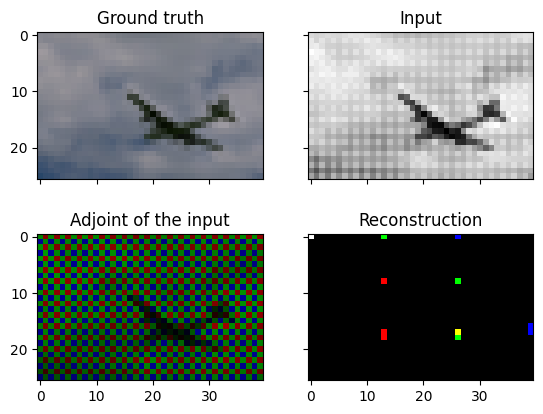

In [32]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

print(peak_signal_noise_ratio(x, x_hat))
axs[0, 0].imshow(x)
axs[0, 0].set_title('Ground truth')
axs[0, 1].imshow(y.cpu(), cmap='gray')
axs[0, 1].set_title('Input')
axs[1, 0].imshow(OP.adjoint(OP.direct(x)))
axs[1, 0].set_title('Adjoint of the input')
axs[1, 1].imshow(x_hat)
axs[1, 1].set_title('Reconstruction')